# Fossilnet inference

We trained **fossilnet** on Google Colab's CPU-accelerated notebook, and saved the model weights in `./geofignet.pt`.

You will need to install [PyTorch](https://pytorch.org/get-started/locally/) version >= 1.4.

In [1]:
import torch
import torchvision

torch.__version__, torchvision.__version__

('1.4.0', '0.5.0')

In [2]:
import torch.nn as nn
from torchvision import datasets, models, transforms

## Instantiate the model

In [3]:
class_names = ['ammonites',
               'bivalves',
               'corals',
               'dinosaurs',
               'echinoderms',
               'fishes',
               'forams',
               'gastropods',
               'plants',
               'trilobites',
              ]

You will need to download the weights from your Google Drive, or you can [use this one](https://drive.google.com/open?id=1Uf7TCzje8sfSrC_mVYjKAjpnHUUuDKdf)

In [4]:
# Instantiate a vanilla ResNet and adjust its shape.
model = models.resnet18()
model.fc = nn.Linear(model.fc.in_features, len(class_names))

# Load the geofignet weights.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('../data/fossilnet.pt', map_location=device), strict=False)

# Set the mode to 'evaluate' before inference, e.g. to disable dropout layers.
_ = model.eval()

## Inference on one image

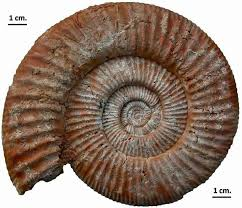

In [34]:
from IPython.display import Image as Img

Img("../data/random_ammonite.jpeg")

In [6]:
from PIL import Image

data_transforms = transforms.Compose([
        transforms.Resize(156),
        transforms.CenterCrop(128),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name).convert('RGB')
    image = data_transforms(image).unsqueeze(0)
    return image.to(device)

image = image_loader("../data/random_ammonite.jpeg")

sm = torch.nn.Softmax(dim=1)
probs = sm(model(image))
prob, clas = torch.max(probs, 1)

In [7]:
class_names[clas]

'ammonites'

We also get the probability of the class selection:

In [8]:
prob.item()

0.9999630451202393

This came from the model output, which is passed through a softmax function:

In [27]:
torch.nn.Softmax(dim=1)(model(image))

tensor([[9.9996e-01, 1.5402e-06, 7.8908e-09, 1.4592e-08, 6.9258e-09, 1.6509e-06,
         8.8937e-10, 3.3352e-05, 3.5197e-07, 2.9455e-08]],
       grad_fn=<SoftmaxBackward>)

This is a torch tensor, which was can convert to a NumPy object for easier manipulation:

In [18]:
 probs.detach().numpy().squeeze()

array([9.9996305e-01, 1.5402355e-06, 7.8907521e-09, 1.4592283e-08,
       6.9257737e-09, 1.6508989e-06, 8.8937469e-10, 3.3351891e-05,
       3.5196729e-07, 2.9455022e-08], dtype=float32)

For example, we could make a plot of the log probability of each class:

In [11]:
import matplotlib.pyplot as plt
import numpy as np

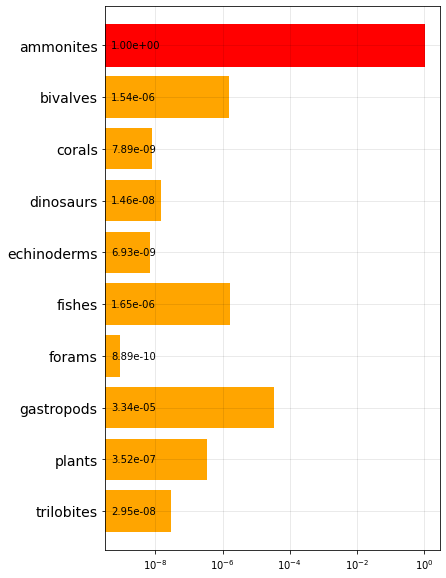

In [21]:
probs_ = probs.detach().numpy().squeeze()
y = np.arange(len(probs_))
y_min, y_max = y[0]-0.75, y[-1]+0.75

fig, ax = plt.subplots(figsize=(6, 10))
bars = ax.barh(y, probs_, color='orange', align='center', lw=2)
ax.set_yticks(y)
ax.set_yticklabels(class_names, size=14)
ax.set_xscale('log')
ax.set_ylim(y_max, y_min)  # Label top-down.
ax.grid(c='black', alpha=0.1, which='both')

for i, p in enumerate(probs_):
    ax.text(0.55*min(probs_), i, f"{p:0.2e}", va='center')

bars[np.argmax(probs_)].set_color('red')

## What next?

If we think our model is doing what we want, we could deploy it in a web app for example. 

See an implementation of `geofignet` here:

> https://geofignet.geosci.ai/

But before we feel too pleased with ourselves:

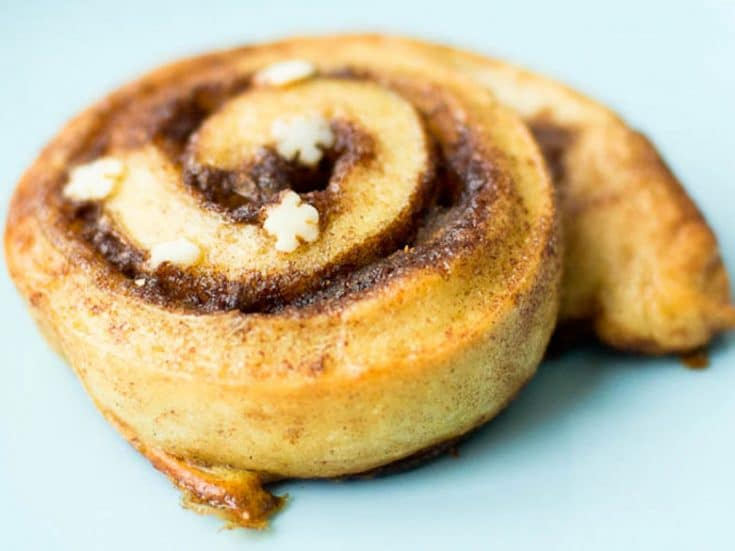

In [36]:
Img("../data/cinnamon.jpg", width=512)

In [28]:
image = image_loader("../data/cinnamon.jpg")

sm = torch.nn.Softmax(dim=1)
probs = sm(model(image))
prob, clas = torch.max(probs, 1)

In [32]:
class_names[clas], prob.item()

('gastropods', 0.8006685972213745)

---
© 2021 Agile Scientific